Parsing training data...
Found 12876 training images with faces.


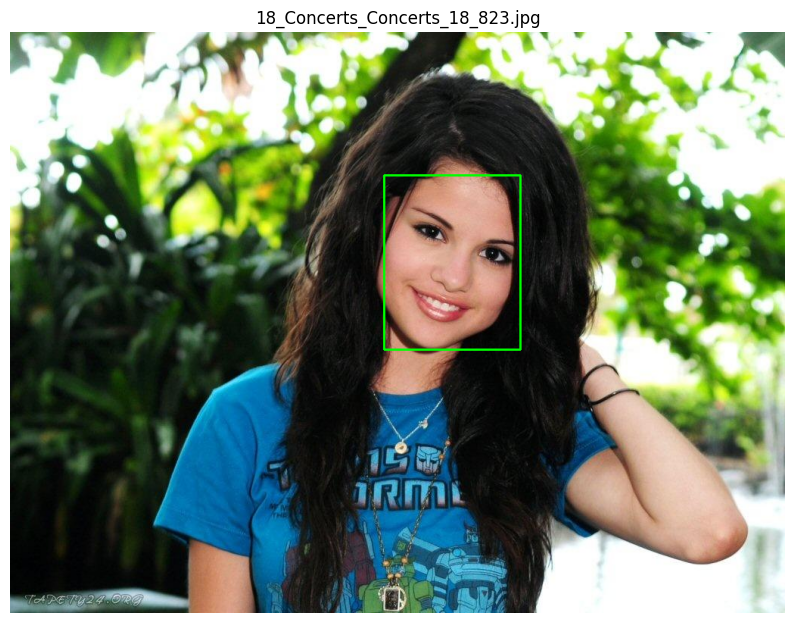

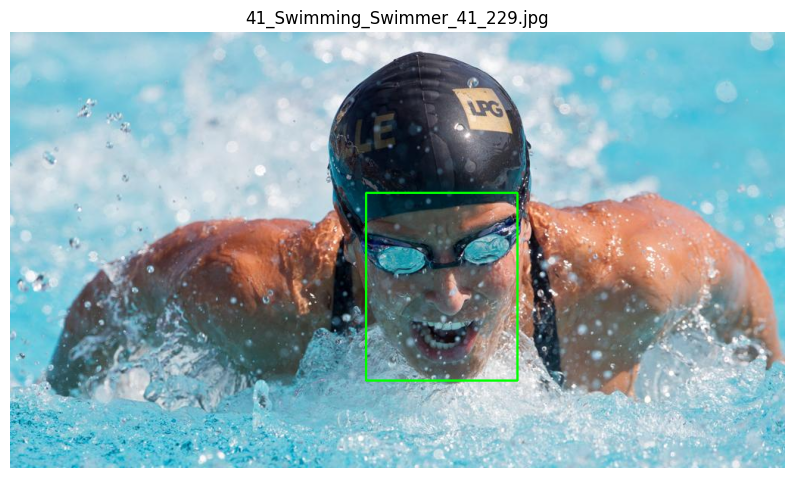

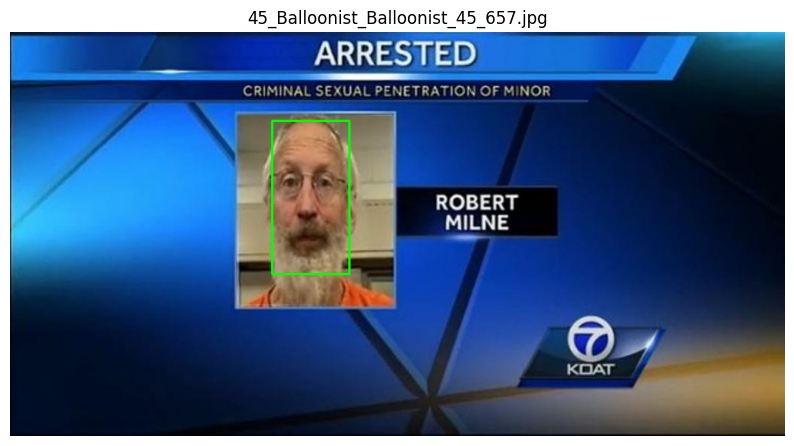

Total number of face bounding boxes in training set: 156994


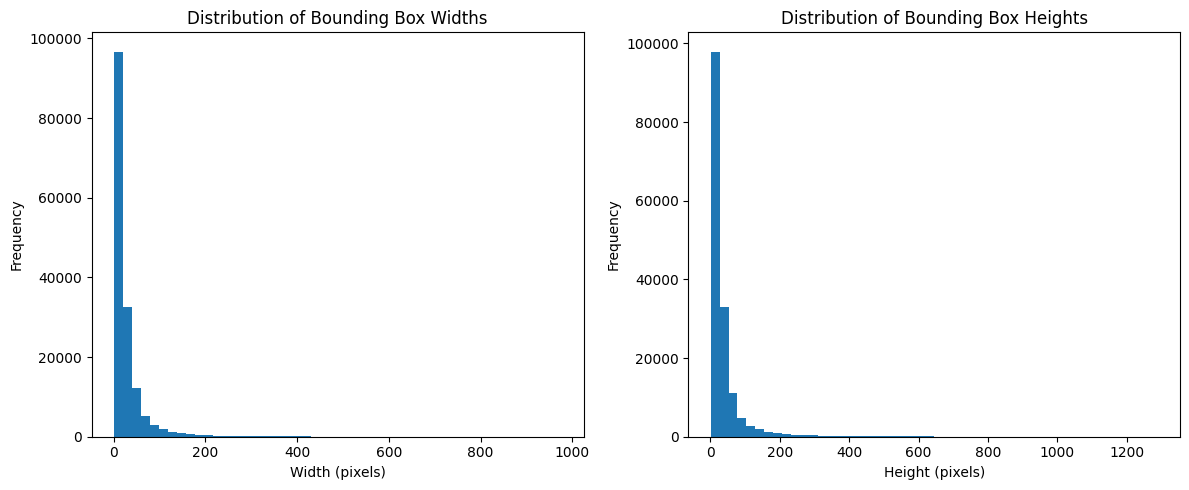

Average width: 29.31, Average height: 37.88
Min width: 1, Max width: 976
Min height: 1, Max height: 1289


In [1]:
# notebooks/01_data_exploration.ipynb

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define base paths (adjust if your structure is different)
WIDER_FACE_DIR = '../data/WIDER_FACE/'
TRAIN_IMAGES_DIR = os.path.join(WIDER_FACE_DIR, 'WIDER_train/images/')
TRAIN_ANNOT_FILE = os.path.join(WIDER_FACE_DIR, 'wider_face_split/wider_face_train_bbx_gt.txt')

VAL_IMAGES_DIR = os.path.join(WIDER_FACE_DIR, 'WIDER_val/images/')
VAL_ANNOT_FILE = os.path.join(WIDER_FACE_DIR, 'wider_face_split/wider_face_val_bbx_gt.txt')

def parse_wider_face_annotations(annot_file_path, images_dir_path):
    """
    Parses WIDER FACE annotation file.
    Returns a list of dictionaries, where each dictionary contains:
    'image_path': full path to the image
    'bboxes': list of [x1, y1, w, h]
    """
    data = []
    with open(annot_file_path, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        image_relative_path = lines[i].strip()
        image_full_path = os.path.join(images_dir_path, image_relative_path)
        i += 1

        num_bboxes = int(lines[i].strip())
        i += 1

        bboxes = []
        # Handle cases where num_bboxes might be 0, but the annotation format still has one line for it
        if num_bboxes == 0:
            # The format might still have a line like "0 0 0 0 0 0 0 0 0 0" for 0 boxes.
            # We need to skip this line.
            # The next line should be a new image file name.
            # Check if the next line looks like an image path or bbox data
            if i < len(lines) and lines[i].strip().count(' ') > 1: # More than 1 space suggests bbox data
                 i +=1 # Skip this "zero" bbox line if present
            # else: it's already the next image path, do nothing special
        else:
            for _ in range(num_bboxes):
                bbox_info = lines[i].strip().split()
                # x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose
                x1, y1, w, h = [int(x) for x in bbox_info[:4]]
                invalid_flag = int(bbox_info[7]) # 0 for valid, 1 for invalid

                # We only care about valid faces and positive width/height
                if w > 0 and h > 0 and invalid_flag == 0:
                    bboxes.append([x1, y1, w, h])
                i += 1
        
        # Only add if the image exists and has valid bounding boxes
        if os.path.exists(image_full_path) and len(bboxes) > 0 : # or num_bboxes == 0 to include images with no faces
            data.append({'image_path': image_full_path, 'bboxes': bboxes})
        elif not os.path.exists(image_full_path):
            print(f"Warning: Image path not found {image_full_path}. Skipping.")
        # If num_bboxes was > 0 but all were invalid or w/h <=0, bboxes might be empty.
        # Decide if you want to include images that originally had annotations but all were filtered out.
        # For now, we only include images with at least one valid face.

    return data

# Parse training annotations
print("Parsing training data...")
train_data = parse_wider_face_annotations(TRAIN_ANNOT_FILE, TRAIN_IMAGES_DIR)
print(f"Found {len(train_data)} training images with faces.")

# Parse validation annotations (optional for now, but good practice)
# print("Parsing validation data...")
# val_data = parse_wider_face_annotations(VAL_ANNOT_FILE, VAL_IMAGES_DIR)
# print(f"Found {len(val_data)} validation images with faces.")


# --- Display a sample image with bounding boxes ---
def display_sample(image_data, num_samples=1):
    for i in range(min(num_samples, len(image_data))):
        sample = image_data[np.random.randint(0, len(image_data))]
        image_path = sample['image_path']
        bboxes = sample['bboxes']

        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image: {image_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Matplotlib uses RGB

        for bbox in bboxes:
            x1, y1, w, h = bbox
            # Draw rectangle: cv2.rectangle(image, pt1, pt2, color, thickness)
            # pt1 = (x1, y1), pt2 = (x1+w, y1+h)
            cv2.rectangle(image, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2) # Green box, thickness 2

        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.title(os.path.basename(image_path))
        plt.axis('off')
        plt.show()

# Display a few samples from the training data
if train_data:
    display_sample(train_data, num_samples=3)
else:
    print("No training data to display.")

# --- Basic Statistics ---
if train_data:
    num_total_faces = sum(len(item['bboxes']) for item in train_data)
    print(f"Total number of face bounding boxes in training set: {num_total_faces}")

    widths = []
    heights = []
    for item in train_data:
        for bbox in item['bboxes']:
            widths.append(bbox[2])
            heights.append(bbox[3])

    if widths and heights: # Check if lists are not empty
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.hist(widths, bins=50)
        plt.title('Distribution of Bounding Box Widths')
        plt.xlabel('Width (pixels)')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        plt.hist(heights, bins=50)
        plt.title('Distribution of Bounding Box Heights')
        plt.xlabel('Height (pixels)')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        print(f"Average width: {np.mean(widths):.2f}, Average height: {np.mean(heights):.2f}")
        print(f"Min width: {np.min(widths)}, Max width: {np.max(widths)}")
        print(f"Min height: {np.min(heights)}, Max height: {np.max(heights)}")
    else:
        print("No bounding boxes found to calculate statistics.")